# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Train from scratch
2. Explore embeddings vectors
3. Use these for an NLP task

In [114]:
import time
import logging
from collections import defaultdict

# NLTK page : http://www.nltk.org/

In [115]:
import nltk
nltk.__version__

'3.2.3'

# Gensim page : https://radimrehurek.com/gensim/index.html

In [116]:
import gensim
gensim.__version__

'3.2.0'

# Scikit-learn page : http://scikit-learn.org/stable/

In [117]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
sklearn.__version__

'0.19.1'

In [118]:
import numpy as np
np.__version__

'1.14.0'

In [119]:
import matplotlib.pyplot as plt

In [120]:
%matplotlib inline

In [121]:
from gensim.models import Word2Vec

In [122]:
%time nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\u0061995\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
Wall time: 281 ms


True

In [123]:
%time nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\u0061995\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Wall time: 124 ms


True

In [124]:
%time nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\u0061995\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Wall time: 102 ms


True

In [125]:
# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\u0061995\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 84.8 ms


True

In [126]:
# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\u0061995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 17.6 ms


True

In [127]:
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

In [128]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [129]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


# Pro Tip : Before we go on, it's good to know about the GenSim documentation for models, training, querying, etc:
https://radimrehurek.com/gensim/models/word2vec.html

In [130]:
# Let's determine what parameters we will use for the word2vec training
W2V_SKIP_GRAM = 0
W2V_DIMENSIONS = 200
W2V_MIN_COUNT = 3

In [131]:
# How many worker threads should we use to train?  Depends on your hardware...
W2V_WORKERS = 1

# Let's train some models...

In [132]:
%time brown_model = Word2Vec(brown.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 28.9 s


In [133]:
%time movie_model = Word2Vec(movie_reviews.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 24.1 s


In [134]:
%time treebank_model = Word2Vec(treebank.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 12.3 s


In [135]:
print('Brown Model vocab size : ', len(brown_model.wv.vocab))
print('Movie Review Model vocab size : ', len(movie_model.wv.vocab))
print('Treebank Model vocab size : ', len(treebank_model.wv.vocab))

Brown Model vocab size :  22339
Movie Review Model vocab size :  20261
Treebank Model vocab size :  3959


# Save / Load models

In [136]:
# Before we go any further, we can save one of our models
brown_file_name = 'brown_' + time.strftime("%m_%d_%Y")
brown_model.save(brown_file_name)
print('Saved Model to : ' + brown_file_name)

Saved Model to : brown_04_02_2018


In [137]:
# and here's how we can load a model back in...
brown_loaded_model = Word2Vec.load(brown_file_name)
print('Brown LOADED Model vocab size : ', len(brown_loaded_model.wv.vocab))

Brown LOADED Model vocab size :  22339


# Let's start inspect our newly trained vectors

In [138]:
# Now let's inspect what some of these vectors look like
print(brown_model['business'])

[-0.1681587  -0.35026997 -0.08549125 -0.12100815 -0.33277643 -0.26714635
 -0.00926656  0.03088769 -0.1881228  -0.2868538   0.21203345  0.0409064
  0.20764758 -0.11353518  0.07808574 -0.38184273 -0.22221924 -0.3006094
  0.33233526  0.36306608  0.39254344 -0.16489878 -0.2655508  -0.23161022
  0.4438861   0.29245216  0.02752603 -0.08852638 -0.8398349  -0.01316171
  0.31794345  0.18744326  0.05759687  0.03673702  0.19491664 -0.07364178
 -0.00116744 -0.3136609  -0.42807353  0.17586789 -0.03582537 -0.2668847
 -0.4651286  -0.06630015 -0.2742809  -0.11015075 -0.06427519  0.10090527
  0.01323994 -0.09991805  0.29557326 -0.11269267  0.02622683 -0.12839934
  0.10795401 -0.4857244   0.22758709  0.60369474  0.01339785  0.34164166
  0.0527631   0.5659563  -0.41215962 -0.30824077  0.14023353  0.19081032
 -0.26519874  0.13869765 -0.00153908 -0.05053359 -0.05493502 -0.13102947
 -0.08510713  0.4167035   0.00625909  0.12141385  0.18228637 -0.00653423
  0.40291747  0.04138578 -0.2760567   0.02272272  0.18

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [139]:
print(movie_model.wv.most_similar(positive = ['movie'], topn = 10))

[('film', 0.9381773471832275), ('picture', 0.8538423776626587), ('sequel', 0.7610276937484741), ('case', 0.7265169620513916), ('ending', 0.7262139916419983), ('premise', 0.708732545375824), ('flick', 0.6982113122940063), ('plot', 0.6791958808898926), ('story', 0.6790134906768799), ('thing', 0.6789088249206543)]


In [140]:
print(movie_model.wv.most_similar(positive = ['hanks'], topn = 10))

[('platt', 0.9401257038116455), ('campbell', 0.9384773969650269), ('thomas', 0.9370149374008179), ('jason', 0.9363089799880981), ('ian', 0.9359754920005798), ('richard', 0.9349414110183716), ('michael', 0.9346367716789246), ('edward', 0.9331327676773071), ('scott', 0.9313567280769348), ('affleck', 0.9309289455413818)]


In [141]:
# Now let's see how similar certain word pairs might be
TERM_SIMILARITY_1 = 'movie'
TERM_SIMILARITY_2 = 'film'

print(movie_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(brown_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(treebank_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))

0.9381773955101625
0.9074073213731734
0.9975171483326977


In [142]:
# Now let's try another pair
TERM_SIMILARITY_3 = 'computer'
TERM_SIMILARITY_4 = 'life'

print(movie_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(brown_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(treebank_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))

0.19564968064835841
0.5845804660447639
0.9992684928114232


In [143]:
# Can we replicate the famous example from this paper:
# "King - Man + Woman ~~ Queen"
# http://www.aclweb.org/anthology/N13-1#page=784
#RELATIONSHIP_WORD_1 = 'woman'
#RELATIONSHIP_WORD_2 = 'king'
#RELATIONSHIP_WORD_3 = 'man'

# this gives what we might expect from the MOVIE corpus
#RELATIONSHIP_WORD_1 = 'films'
#RELATIONSHIP_WORD_2 = 'movie'
#RELATIONSHIP_WORD_3 = 'film'

# this gives what we might expect from the BROWN corpus
RELATIONSHIP_WORD_1 = 'families'
RELATIONSHIP_WORD_2 = 'city'
RELATIONSHIP_WORD_3 = 'family'

#print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('cities', 0.9448072910308838), ('various', 0.9441609382629395), ('classes', 0.9403717517852783), ('towns', 0.9345503449440002), ('programs', 0.934226930141449), ('departments', 0.9307498931884766), ('methods', 0.9268441200256348), ('roads', 0.9260457158088684), ('organizations', 0.9246764183044434), ('policies', 0.9220679998397827)]


# Now let's try to visualize some of the embeddings vectors with reduced dimensions (by way of t-SNE)

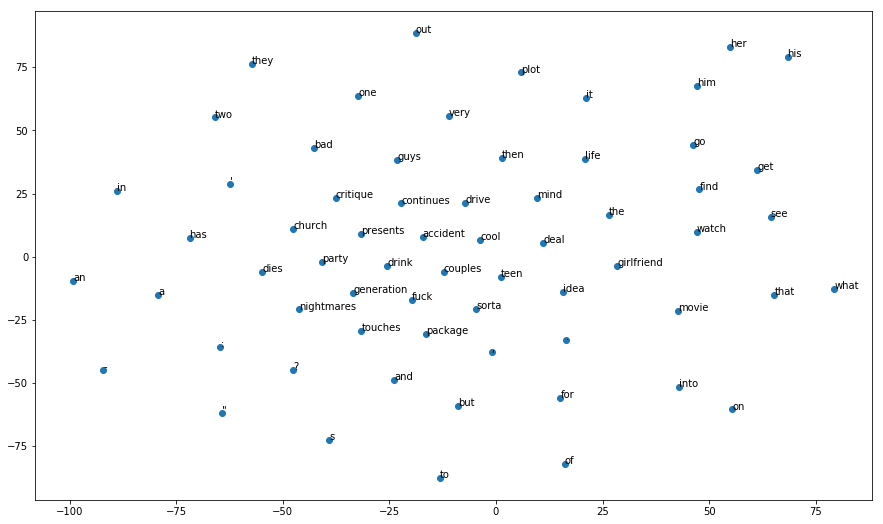

In [144]:
def plot_embeddings(w2v_model, target_terms):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        if target_term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model.wv[target_term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_terms, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
max_movie_sentences_to_visualize = 8
visualization_terms = set()
for sentence in movie_reviews.sents()[:max_movie_sentences_to_visualize]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings(movie_model, list(visualization_terms))

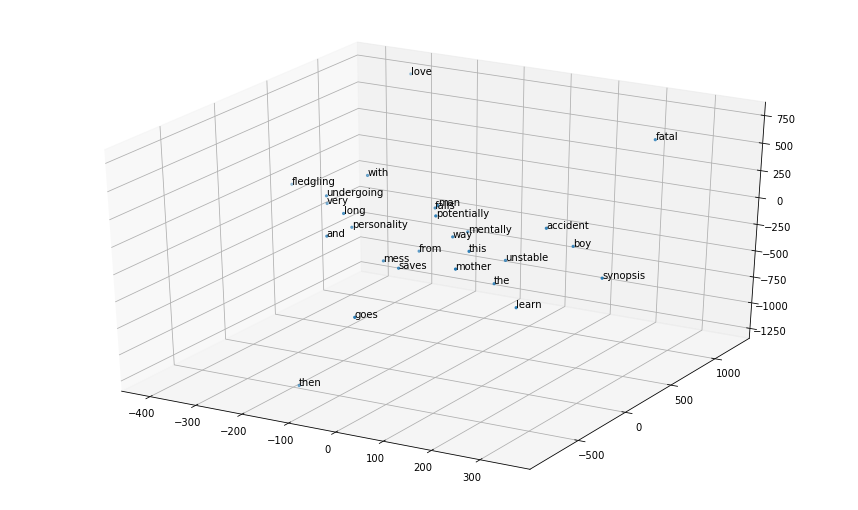

In [145]:
def plot_embeddings_3d(w2v_model, target_terms, min_word_length = 2):
    from mpl_toolkits.mplot3d import Axes3D
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    filtered_terms = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        # make sure that we're either not filtering or its above a certain length
        if min_word_length < 0 or len(target_term) > min_word_length:
            if target_term in w2v_model.wv.vocab:
                term_vectors.append(w2v_model.wv[target_term])
                filtered_terms.append(target_term)
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='.')
    for i, word in enumerate(filtered_terms):
        ax.text(x=Y[i,0], y=Y[i,1], z=Y[i,2], s=word)
    plt.show()
    
max_movie_sentences_to_visualize = 5
visualization_terms = set()
for sentence in movie_reviews.sents()[105:107]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings_3d(movie_model, list(visualization_terms))

{"you're", 'won', 'your', 'nor', 'during', 'weren', 'against', 'needn', "wasn't", 'has', 'by', 'm', 'above', 'haven', 'mustn', 're', 'very', 'wouldn', "didn't", 'couldn', 'then', 'hadn', 'few', 've', 'before', 'itself', 'if', 'wasn', "you've", 'isn', 'ourselves', 'themselves', 'myself', 'until', 'this', 'no', 'mightn', 'here', 'just', 'i', 'him', 'again', 'at', 'll', 'more', 'yourself', 'which', 'yourselves', 'between', "hasn't", 'of', 'my', 'or', 't', 'for', 'they', "it's", 'be', 'will', "won't", 'through', 'there', 'hasn', 'their', 'whom', 'own', 'to', 'how', "couldn't", 'as', 'further', "mightn't", "doesn't", 'and', 'most', 'so', "should've", 'after', 'y', 'ain', 'aren', 'didn', 'where', 'doesn', 'the', 'did', 'it', 'am', 'have', 'her', 'on', 'was', 'we', "that'll", 'does', 'some', "shouldn't", 'a', 'but', 'o', 'under', 's', 'd', 'an', 'are', 'hers', 'when', 'our', 'other', 'now', "you'd", 'his', "you'll", 'been', 'in', 'any', 'only', 'off', 'too', 'who', 'than', 'below', 'don', 'sa

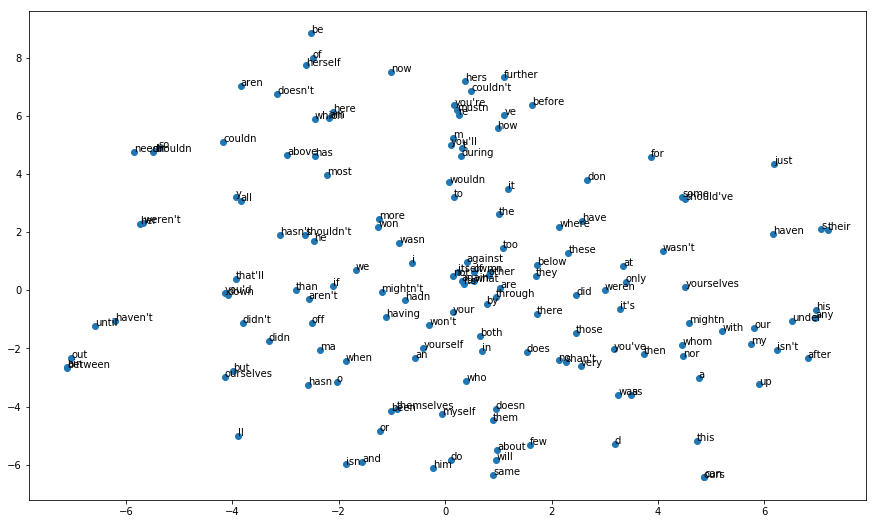

In [146]:
# here are some terms we can plot...
english_stop_words = set(nltk.corpus.stopwords.words('english'))
print(english_stop_words)
plot_terms = english_stop_words
plot_embeddings(movie_model, plot_terms)

# Now let's try to use these embeddings to do some classification. 

In [147]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the mean()
        return np.array([
            np.mean([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.vocab)

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.wv[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    
class MaxEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the max()
        return np.array([
            np.max([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])

In [148]:
lr_mean_w2v = Pipeline([
    ("word2vec mean vectorizer", MeanEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_max_w2v = Pipeline([
    ("word2vec max vectorizer", MaxEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_tfidf_w2v = Pipeline([
    ("word2vec TF-IDF vectorizer", TfidfEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

In [149]:
X = [movie_reviews.words(fileid) for fileid in movie_reviews.fileids()]
# these are the categories
y_categories = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]
# this maps the strings to 1 -> positive 0 -> negative (anything else)
y = [1 if category == 'pos' else 0 for category in y_categories ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

In [150]:
lr_mean_w2v.fit(X_train,y_train)

mean_w2v_f1 = f1_score(y_test, lr_mean_w2v.predict(X_test))
print('Word2Vec mean embeddings F1 : {}'.format(mean_w2v_f1))

Word2Vec mean embeddings F1 : 0.6766169154228856


In [151]:
lr_max_w2v.fit(X_train,y_train)

max_w2v_f1 = f1_score(y_test, lr_max_w2v.predict(X_test))
print('Word2Vec max embeddings F1 : {}'.format(max_w2v_f1))

Word2Vec max embeddings F1 : 0.6084788029925188


In [152]:
lr_tfidf_w2v.fit(X_train,y_train)

tfidf_w2v_f1 = f1_score(y_test, lr_tfidf_w2v.predict(X_test))
print('Word2Vec TF-IDF weighted embeddings F1 : {}'.format(tfidf_w2v_f1))

Word2Vec TF-IDF weighted embeddings F1 : 0.6750629722921914


# Let's also compare against a bag of words pipeline

In [154]:
# set up a simple bag of words model
bow_pipeline = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

X_train_text = [' '.join(sentence) for sentence in X_train]
X_test_text = [' '.join(sentence) for sentence in X_test]
bow_pipeline.fit(X_train_text,y_train)

bow_f1 = f1_score(y_test, bow_pipeline.predict(X_test_text))
print('Bag of Words F1 : {}'.format(bow_f1))

Bag of Words F1 : 0.7914691943127962
